# Image Subtraction Module

**Lecturer:** Christoffer Fremling<br>
**Jupyter Notebook Authors:** Igor Andreoni, Christoffer Fremling and Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2020.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2020.html

CLD Note: Making notes, Feb 2024!

## Objective
Learn how to perform image subtraction to discover astronomical transients from multiple consecutive images.

## Key steps
- Register science and reference images (make them aligned and of the same size)
- PSF extraction, using PSFex
- PSF matching by convolution
- [Zero-point calibration]
- Image subtraction

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib
* pytest
* photutils

### External packages
* SWarp https://www.astromatic.net/software
* SExtractor https://www.astromatic.net/software
* PSFex https://www.astromatic.net/software
* ds9 http://ds9.si.edu/site/Home.html 

had to pip install image_registration and pytest

In [1]:
# Import the relevant packages

import numpy as np
from astropy.io import fits #FITS files handling
import os  #Call commands from outside Python
from astropy.io import ascii  #Read/write ascii files

# Useful to smooth the images with a Gaussian kernel before the subtraction
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve 
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats

from astropy.coordinates import SkyCoord
from astropy import units as u

# Background subtraction
from astropy.stats import SigmaClip
#from photutils import Background2D, MedianBackground
from photutils.background import Background2D, MedianBackground # had to update root package name here
from photutils.segmentation import SegmentationImage # this line used to be:
#from photutils import make_source_mask
# So that will be a problem

## ^^ This last line is giving us tons of problems!


# Image registration
from image_registration import chi2_shift
from image_registration.fft_tools import shift
import scipy
from scipy import ndimage, misc
import numpy.fft

# Plot
import matplotlib.pyplot as plt

# Running external programs
import subprocess
import shutil

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


External packages

SWarp https://www.astromatic.net/software

SExtractor https://www.astromatic.net/software (this is in apt, but didn't work so trying source...:)

    needs fftw, fftw2 from apt didn't work, trying source on that. trying to configure single preciion AND float (via sextractor INSTALL file)....

passed that, now "ATLAS Header files not found". Installed via apt: libatlas-base-dev. Finally getting to make

None of that is working, going back to apt install, but CHANGING NAME!!! to source-extractor.

PSFex https://www.astromatic.net/software (in apt!)

ds9 http://ds9.si.edu/site/Home.html (seems to just be a binary, so putting it in /usr/local/bin!)



## Test dependencies

In order for this jupyter notebook to function correctly, we must have some external software installed, as described above.  The following step assures that these are installed properly before getting to the rest of the content of this lesson.

In [2]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0

#dependencies = [('sextractor', 'sex'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")   

sextractor is installed properly as source-extractor. OK
SWarp is installed properly as swarp. OK
psfex is installed properly as psfex. OK
ds9 is installed properly as ds9. OK
4 out of 4 external dependencies installed properly.

You are ready to continue.


## Set up paths and clear old temp files

In [3]:
# remove temporary fits files in current working directory
[os.remove(f) for f in os.listdir() if f.endswith('.fits')]

# Set directory structure
cwd = os.getcwd()
print("You start from the directory:", cwd)
print("If you are not in the image_subtraction/ directory, use os.chdir() to get there")

proc_dir = os.path.join(cwd, 'processed')
data_dir = os.path.join(cwd, 'data')
out_dir = os.path.join(proc_dir, 'out')
if os.path.isdir(proc_dir): 
    shutil.rmtree(proc_dir)
os.mkdir(proc_dir)

for f in os.listdir(data_dir):
    shutil.copy2(os.path.join(data_dir, f), os.path.join(proc_dir, f))
os.chdir(proc_dir)
print("You are working in the image_subtraction/processed/ directory")
print("Full path:", proc_dir)

You start from the directory: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction
If you are not in the image_subtraction/ directory, use os.chdir() to get there
You are working in the image_subtraction/processed/ directory
Full path: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed


## Reference and science images

Define the reference and science images. Open them with ds9 to give them a look. <br /> (THIS DIDN'T HAPPEN...)
Also, what is the size of the images in pixel?  This information will be useful when we want to align the images using Swarp.

In [4]:
# Reference image
ref_image_name = os.path.join(data_dir, 'refimg_i.fits')
ref_image = fits.open(ref_image_name)

# Plot up the reference image
mean, median, std = sigma_clipped_stats(ref_image[0].data)
plt.figure(figsize=(8,8))

# Set the scale of the image based on its statistics
# p/m two sigma.
plt.imshow(ref_image[0].data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar()
plt.title('Reference image')
plt.show()

# Image size?
print("The dimension of the X axis of the reference image is ")
print(ref_image[0].header["NAXIS1"])
print("The dimension of the Y axis of the reference image is ")
print(ref_image[0].header["NAXIS2"])

FileNotFoundError: [Errno 2] No such file or directory: '/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/refimg_i.fits'

### Exercise:
Let's do the same for the science image.  Can you already spot the Supernova? 

In [9]:
# Science image
sci_image_name = os.path.join(data_dir, '20120419094409p.fits')
sci_image = fits.open(sci_image_name)

# Open the images - uncomment or open from the ds9 app
# Test ds9!
os.system('ds9 -zscale '+sci_image_name +' ' + ref_image_name +'&')

0

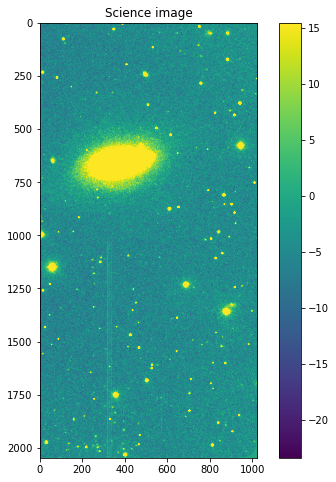

In [10]:
# Plot up the science image
mean, median, std = sigma_clipped_stats(sci_image[0].data)
plt.figure(figsize=(8,8))

# set the scale of the image based on its statistics
plt.imshow(sci_image[0].data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar()
plt.title('Science image')
plt.show()



In [11]:
# Image size?
print("The dimension of the X axis of the science image is ")
print(sci_image[0].header["NAXIS1"])
print("The dimension of the Y axis of the science image is ")
print(sci_image[0].header["NAXIS2"])

The dimension of the X axis of the science image is 
1024
The dimension of the Y axis of the science image is 
2048


## Align the images

Use the AstrOmatic Swarp package to align the images.  Swarp relies on the astrometric information of the image (in other words, on the sky coordinates), therefore both the science and reference images must be astrometrically calibrated (for example, using the AstrOmatic SCAMP package).  In this module we assume that the input images are already calibrated.

In [80]:
# Swarp command
# had to change capitalization of SWarp!
try:
    command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name, ref_image_name, os.path.join(data_dir, 'config.swarp'))
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SWarp with exit error %s'%err)

# Names of the aligned images
sci_image_aligned_name = sci_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
ref_image_aligned_name = ref_image_name.replace(".fits", ".resamp.fits").replace('data','processed')

Executing command: swarp /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/data/20120419094409p.fits /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/data/refimg_i.fits -c /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/data/config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900


> 
----- SWarp 2.41.5 started on 2024-02-13 at 16:21:51 with 12 threads

> Examining input data ...
> Looking for 20120419094409p.fits ...
> Looking for refimg_i.fits ...
> Creating NEW output image ...
> Creating NEW weight-map ...
> 
------- Output File swarpout.fits:
    "no ident"  WEIGHTED  no ext. header  1800x900  32 bits (floats)
    Center: 15:00:10.62 +01:54:13.4   11.3'x5.67'  Scale: 0.3783 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input data ...
> 
-------------- File 20120419094409p.fits:
    "PTF12os"  unweighted  no ext. header  1024x2048  32 bits (floats)
    Center: 15:00:09.72 +01:54:17.0   6.46'x12.9'  Scale: 0.3782 ''/pixel
    Gain: 4 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X
> Setting up background maps ...
> Setting up background map at line:    512 / 2048   
> Setting up background map at line:   1024 / 2048   
> Setting up background map at line:   1536 / 2048   
> Filtering background map(s) ...
> Computing backgou

Success!


> Closing files ...
> 
> All done (in 0.2 s)


### Exercise:
If we attempt an image subtraction now, what does the result look like?

GOOD EXERCISE! This is what we *want* to work to see the SN.

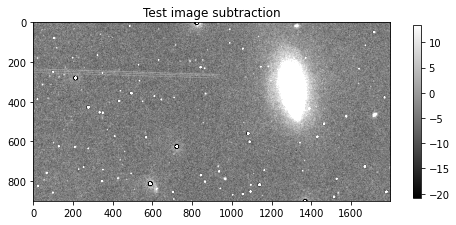

In [81]:
# Test image subtraction:
ref_image_aligned = fits.open(ref_image_aligned_name)
hdr_ref = ref_image_aligned[0].header #save fits header
sci_image_aligned = fits.open(sci_image_aligned_name)
hdr_sci = sci_image_aligned[0].header #save fits header

# Perform the image subtraction
# looks like creating a new fits image, so going back to that tutorial....
image_sub = sci_image_aligned[0].data - ref_image_aligned[0].data
hdu_image_sub = fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_test_0.fits", overwrite = True)

# Plot up the result of the image subtraction
mean, median, std = sigma_clipped_stats(hdu_image_sub.data)
plt.figure(figsize=(8,8))

# Set the scale of the image based on its statistics
plt.imshow(hdu_image_sub.data, vmin=median-2*std, vmax=median+2*std, cmap='gray')
plt.colorbar(shrink=0.4)
plt.title('Test image subtraction')
plt.show()

doesn't reallly convince me, let's try ds9:

In [1]:
os.system('ds9 -zscale sub_test_0.fits &')

NameError: name 'os' is not defined

Yeah ok, that might be an image subtraction....

# Background Subtraction
- Mask sources in images
- Use 3 sigma clipping to filter data and accurately measure the backgorund
- Then split image into 300x300 pixel boxes and apply 2x2 median filter

These lines need work, as they reference what looks to be an old version of SegmentationImage:...

even worse, can't figure out how the version connects. Trying to come up with a new process via https://photutils.readthedocs.io/en/stable/detection.html#masking-regions

In [104]:
# original mask code
#mask_sci = make_source_mask(sci_image_aligned[0].data, snr=2, npixels=3, dilate_size=11)
#mask_ref = make_source_mask(ref_image_aligned[0].data, snr=2, npixels=3, dilate_size=11)

In [83]:
import photutils

In [84]:
# These didn't all pass, not sure I care...
#photutils.test()

In [85]:
from photutils.detection import DAOStarFinder
mean, median, std = sigma_clipped_stats(sci_image[0].data)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(sci_image[0].data - median)  
sources

<QTable length=81>
  id      xcentroid      ...        flux                mag         
int64      float64       ...      float64             float64       
----- ------------------ ... ------------------ --------------------
    1  387.2368136442798 ...  1.475416898727417 -0.42228688338615034
    2  386.6724144762213 ...  1.023409128189087 -0.02512321574226518
    3  748.1300510500705 ...  4.063121318817139  -1.5221494747836837
    4  346.3247290820066 ...  5.029325008392334  -1.7537742544880608
    5 108.91855579821119 ...  6.841403961181641   -2.087863086912303
  ...                ... ...                ...                  ...
   77  463.2974095251828 ...  2.224405288696289   -0.868034797437355
   78  809.1178587279285 ...  12.09994125366211   -2.706958154453871
   79 216.03080770099348 ... 3.3057754039764404   -1.298183360137044
   80  279.0660720900875 ... 1.1455451250076294 -0.14753050368655185
   81  399.8061475562853 ... 32.755760192871094   -3.788219207384944

Let’s plot the image and mark the location of detected sources:

In [86]:
#import numpy as np
#import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

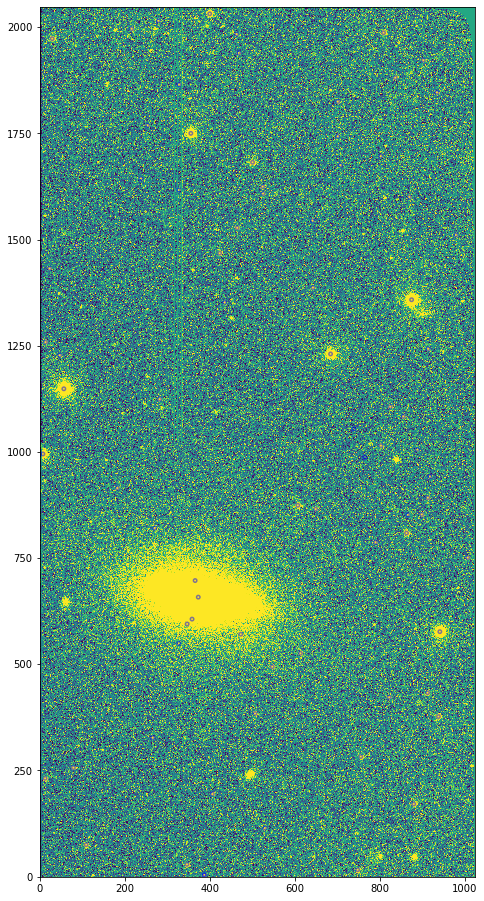

In [87]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
#norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(16,16))
plt.imshow(sci_image[0].data, origin='lower',interpolation='nearest',vmin=median-2*std, vmax=median+2*std)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

Fine, but really we want to catch all the peaks above some background level, like the original task. I think that's actually this:

In [88]:
from photutils.detection import find_peaks
mean, median, std = sigma_clipped_stats(sci_image[0].data)
threshold = median + (5.0 * std)
tbl = find_peaks(sci_image[0].data, threshold, box_size=11)
tbl

<QTable length=283>
x_peak y_peak peak_value
int64  int64   float32  
------ ------ ----------
   387      4  123.94954
   748     16  412.94568
   346     29  447.25873
   881     47  151.89793
   802     48  46.015686
   ...    ...        ...
   463   1984  199.92802
   809   1987   1108.823
   216   1996  268.19946
   279   2016  107.68678
   400   2032  2951.2625

Plot that...

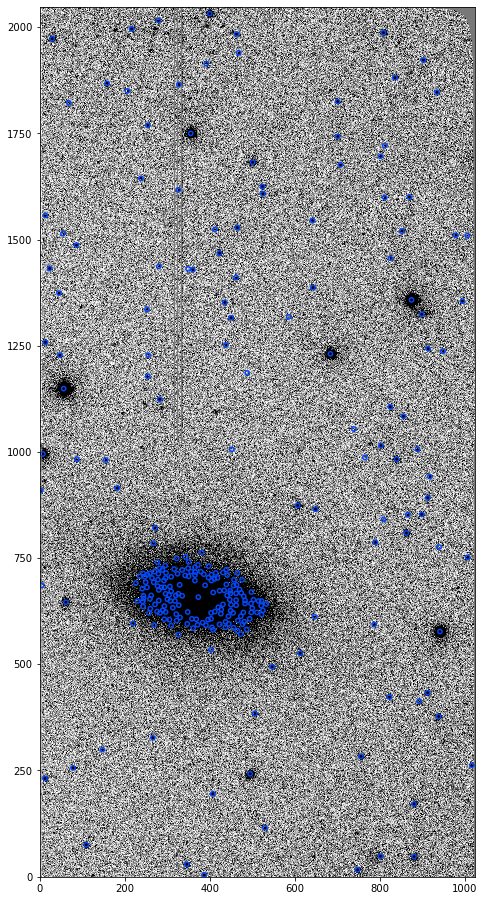

In [89]:
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.0)
plt.figure(figsize=(16,16))
plt.imshow(sci_image[0].data, origin='lower',interpolation='nearest',vmin=median-2*std, vmax=median+2*std,cmap='Greys')
apertures.plot(color='#0547f9', lw=1.5)

Still not quite the right thing, I think we just want to mask EVERY pixel that's over some value (SNR=2 in their examples)

Now looking in more detail at image segmentation: https://photutils.readthedocs.io/en/stable/segmentation.html#pixel-masking

finding the conditions that match the original (here: https://buildmedia.readthedocs.org/media/pdf/photutils/v0.3.1/photutils.pdf) are tricky, since they started with snr=2 (snr above background to consider a source), npixels=3 (number of connected pixels above background to be considered a source) and dilate_size=11 (number of pixels square to "dilate" the image - what? Sounds like part of the algorithm). the "connectedness" is tricky, since the new algorithm has "8 connected", and it *seems*  like the old version defaulted to this as well)

In [122]:
# remove temporary fits files
if os.path.exists(sci_image_aligned_name): os.remove(sci_image_aligned_name)
if os.path.exists(ref_image_aligned_name): os.remove(ref_image_aligned_name)

#estimate background first (without a mask)
bkg_estimator = MedianBackground()
sci_image_aligned_name = os.path.join(proc_dir, "bg_sub_sci.fits")
ref_image_aligned_name = os.path.join(proc_dir, "bg_sub_ref.fits")
sigma_clip = SigmaClip(sigma=3)
# no idea what these 200,150 numbers are, came from GROWTH. box size to be used, but they removed the galaxy first!
bkg_sci = Background2D(sci_image_aligned[0].data, (200, 150), filter_size=(3, 3),bkg_estimator=bkg_estimator)
bkg_ref = Background2D(ref_image_aligned[0].data, (200, 150), filter_size=(3, 3),bkg_estimator=bkg_estimator)


In [123]:
thresh_sci = 2 * bkg_sci.background_rms # 2 from GROWTH
thresh_ref = 2 * bkg_ref.background_rms

Now detect sources

In [124]:
from photutils.segmentation import detect_sources
segment_map_sci = detect_sources(sci_image_aligned[0].data, thresh_sci, npixels=10)
segment_map_ref = detect_sources(sci_image_aligned[0].data, thresh_sci, npixels=10)
print(segment_map_sci)

<photutils.segmentation.core.SegmentationImage>
shape: (900, 1800)
nlabels: 139
labels: [  1   2   3   4   5 ... 135 136 137 138 139]


Plot them to confirm...

Text(0.5, 1.0, 'Segmentation Image')

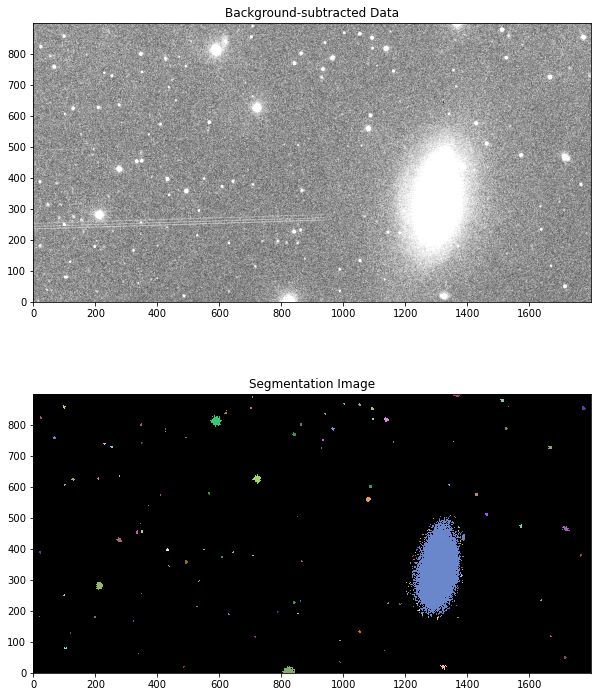

In [102]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(sci_image_aligned[0].data, origin='lower', cmap='Greys_r',vmin=median-2*std, vmax=median+2*std)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')

I mean yeah, that's what I would expect I think. After all that work....I don't know that I actually need the masks! Maybe the super bright galaxy means that I do...

Leave them, subtract the background!

(NO! When I did this and compared to the their results, the "background subtracted" as very clear evidence of the galaxy still in it, so it's impacting the background. Try to make the aligned images, and THEN estimate and subtract background.)


In [120]:
bkg_sci = Background2D(sci_image_aligned[0].data, (200, 150), filter_size=(3, 3),bkg_estimator=bkg_estimator,mask=segment_map_sci)
bkg_ref = Background2D(ref_image_aligned[0].data, (200, 150), filter_size=(3, 3),bkg_estimator=bkg_estimator,mask=segment_map_ref)

In [125]:
# Remove the background from the science image
sci_image_aligned[0].data = sci_image_aligned[0].data - bkg_sci.background
hdu_image_sub = fits.PrimaryHDU(sci_image_aligned[0].data)
hdu_image_sub.writeto(sci_image_aligned_name)

# Remove the background from the reference image
ref_image_aligned[0].data = ref_image_aligned[0].data - bkg_ref.background
hdu_image_sub = fits.PrimaryHDU(ref_image_aligned[0].data)
hdu_image_sub.writeto(ref_image_aligned_name)

In [126]:
#original background removal code

# Remove the background from the science image
#sci_image_aligned[0].data = sci_image_aligned[0].data - bkg_sci.background
#hdu_image_sub = fits.PrimaryHDU(sci_image_aligned[0].data)
#hdu_image_sub.writeto(sci_image_aligned_name)

# Remove the background from the reference image
#ref_image_aligned[0].data = ref_image_aligned[0].data - bkg_ref.background
#hdu_image_sub = fits.PrimaryHDU(ref_image_aligned[0].data)
#hdu_image_sub.writeto(ref_image_aligned_name)

What do the background-subtracted images look like?

Executing command: ds9 /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/processed/bg_sub_sci.fits /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/processed/bg_sub_ref.fits
Success!


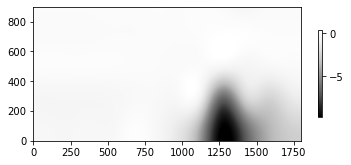

In [127]:
# Display with ds9
try:
    command = "ds9 %s %s" % (sci_image_aligned_name, ref_image_aligned_name)
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run ds9 with exit error %s'%err)

# Plot here the background image
plt.imshow(bkg_sci.background, origin='lower', cmap='Greys_r')
plt.colorbar(shrink=0.4)
#plt.imshow(sci_image_aligned[0].data-bkg_sci.background, origin='lower', cmap='Greys_r')

Ok the subtraction is not great, but at least it's small (Wait....-5!? that might be bad, we may need to mask out the entire galaxy or something).

Get this into the reference image and move forward....

## PSF matching

The atmosphere heavily affects the PSF of the images by determining the "seeing" conditions. The seeing for ground-based optical telescopes is usually measured as the FWHM of the imaging PSF.  Properties of the atmosphere can change very rapidly, so it is rare that science and reference images are characterized by the same seeing. Therefore their PSFs are usually different, which is a problem for image subtraction. 


### Generate the kernel for the convolution

The PSF of the science and reference images can be matched in several different ways.  Here we start by performing a first source extraction on both the science image.  We can use the catalogs of sources that we obtain for two main purposes: <br />
1. Measure the PSF of the science frame, using PSFex or photutils
2. Obtain instruments magnitudes that will be the basis for the zero-point calibration (see Photometry module).  

In [129]:
if os.path.exists('prepsfex.cat'): #Remove possible temporary files
    os.remove("prepsfex.cat") 
try:
    #command = "sextractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: source-extractor /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/processed/bg_sub_sci.fits -c /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/data/prepsfex.sex -CATALOG_NAME /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!


Now we use another software part of the AstrOmatic suite, PSFex, to measure the PSF of the science image. PSFex estimates the PSF based on the information present in the catalog generated with SExtractor.  Then, let's plot the PSF model obtained with PSFex

Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



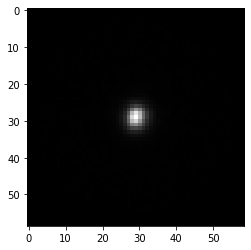

In [130]:
# Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
if not os.path.isdir('out'): os.mkdir('out')

try:
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_sci_image_name = os.path.join(out_dir,'proto_prepsfex.fits')
print(psf_sci_image_name)
psf_sci_image = fits.open(psf_sci_image_name)

plt.imshow(psf_sci_image[0].data[0], cmap='gray')


Looks like a mostly round ball...that's good?

### Convolve the reference image with the PSF of the science image
Now that the kernel is generated, let's convolve the reference image with the PSF of the science frame.  

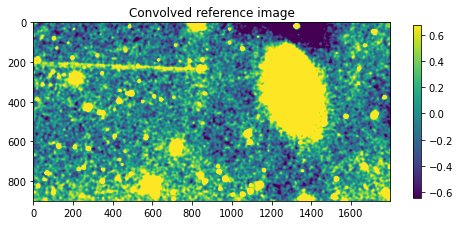

In [131]:
# Convolve the reference image with the PSF of the science frame
if os.path.exists(os.path.join(proc_dir, 'ref_convolved.fits')): 
    os.remove(os.path.join(proc_dir, 'ref_convolved.fits'))

kernel_sci = psf_sci_image[0].data[0]
ref_image_aligned = fits.open(ref_image_aligned_name)
ref_conv = scipy_convolve(ref_image_aligned[0].data, kernel_sci, mode='same', method='fft')

# Create a new fits file for the convolved image
hdu_ref_conv = fits.PrimaryHDU(ref_conv,hdr_ref)
hdu_ref_conv.writeto(os.path.join(proc_dir, "ref_convolved.fits"))

# Plot up the convolved reference image
mean, median, std = sigma_clipped_stats(hdu_ref_conv.data)
plt.figure(figsize=(8,8))

# set the scale of the image based on its statistics
plt.imshow(hdu_ref_conv.data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved reference image')
plt.show()


Note that this matches the original instructions reasonably well.

### Convolve the science image with the PSF of the reference image

(Ok, but this is dumb for our purposes, we just want them to match, right? NEVERMIND, instructions below suggest the convolution should go both ways for them to match, I guess that makes sense! I think I've also seen convolution a ratio of the image or something for this task as well)

### Exercise:

Same as above, but this time we generate a kernel with the properties of the PSF of the reference image.  Then, we convolve the science image with this kernel.

In [134]:
#SExtractor command for the ref image
# overwriting the catalog, but I guess that doesn't matter much.
# note that .sex file is the configuration for source-extractor.
if os.path.exists('prepsfex.cat'): 
    os.remove("prepsfex.cat")

try:
    #command = "???"
    command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (ref_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: source-extractor /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/processed/bg_sub_ref.fits -c /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/data/prepsfex.sex -CATALOG_NAME /home/cduston/Dropbox/Research/Astronomy/SNe/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!


Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



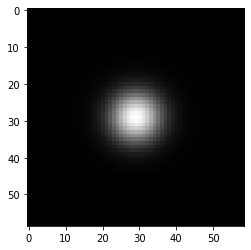

In [135]:
#Run PSFex to compute PSF, read and display the final model 
if os.path.exists(os.path.join(out_dir,'proto_prepsfex.fits')): 
    os.remove(os.path.join(out_dir, 'proto_prepsfex.fits'))

try:
    #command = "???"
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_ref_image_name = os.path.join(out_dir, 'proto_prepsfex.fits')
psf_ref_image = fits.open(psf_ref_image_name)

plt.imshow(psf_ref_image[0].data[0], cmap='gray')


Bigger PSF!

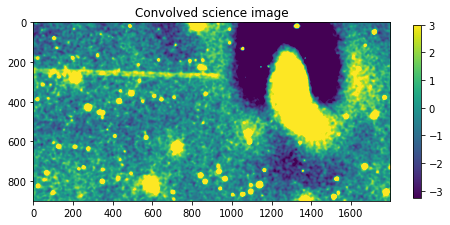

In [136]:
kernel_ref = psf_ref_image[0].data[0]

# Read the SCIENCE image and convolve it with the PSF of the reference frame
sci_image_aligned = fits.open(sci_image_aligned_name)
#sci_conv = ???
sci_conv = scipy_convolve(sci_image_aligned[0].data, kernel_ref, mode='same', method='fft')

# Create a new fits file for the convolved image
hdu_sci_conv = fits.PrimaryHDU(sci_conv,hdr_sci)
hdu_sci_conv.writeto("sci_convolved.fits", overwrite = True)

# Plot up the convolved science image
mean, median, std = sigma_clipped_stats(hdu_sci_conv.data)
plt.figure(figsize=(8,8))

# set the scale of the image based on its statistics
plt.imshow(hdu_sci_conv.data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved science image')
plt.show()


This one does NOT match the original that well, indeed, it's that region of the background around (0,1300) that is not doing well

### Improving the alignment
Now that the science image is convolved with (an approximation of) the PSF of the reference image, 
and the reference image is convolved with the PSF of the science image, we can perform the image subtraction.

- Before the subtraction we use an fft method (chi_2_shift) to fine-tune the image alignment of the reference and science image

In [137]:
# Fine tuning of image alignment

xoff, yoff, exoff, eyoff = chi2_shift(ref_conv, sci_conv, 10, return_error=True, upsample_factor='auto')
print("Alignment offsets:",xoff,yoff)

sci_conv_shift = scipy.ndimage.shift(sci_conv, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)



Alignment offsets: 0.474609375 -0.130859375


## Normalization of the images

The science and reference images are usually obtained with different exposure times.  In addition, the reference image can be the stack of several images to increase the depth.  Finally, different CCDs of the same camera (or even different regions of the same CCD when multiple amplifiers are present) may have slightly different gain. <br >

The background subtraction should have removed the non-linear offsets between science and reference images.  We can therefore normalize the two images by computing the ratio of bright star fluxes in the two images. Once again, we use SExtractor to extract the flux and other quantities.

In [138]:
# Normalize images using the stars in the image

# Run SExtractor on the science image
#sextractor_command = "sextractor sci_convolved.fits -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"
sextractor_command = "source-extractor sci_convolved.fits -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"


try:
    command = sextractor_command
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

cat_sci = ascii.read('sci_match.cat')


# Run SExtractor on the reference image
#sextractor_command = "sextractor ref_convolved.fits -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"
sextractor_command = "source-extractor ref_convolved.fits -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"


try:
    command = sextractor_command
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

# Read in the SExtractor output catalog
cat_ref = ascii.read('ref_match.cat')


Executing command: source-extractor sci_convolved.fits -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!
Executing command: source-extractor ref_convolved.fits -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!


Match the catalog of sources of the reference and science images.  Calculate the ratio between the flux of source in the science image over the flux of sources in the reference image.

In [139]:
c1 = SkyCoord(ra=cat_sci['X_WORLD'], dec=cat_sci['Y_WORLD'])
c2 = SkyCoord(ra=cat_ref['X_WORLD'], dec=cat_ref['Y_WORLD'])

idx, d2d, d3d = c1.match_to_catalog_3d(c2)

# Initialize a list for the indexes and one for the flux ratios
index_arr = []
ratio_arr = []

for i, i2, d in zip(idx, np.arange(len(d2d)),d2d):
    #print(i,d)
    index_arr.append(i)
    print("Image coordinates")
    print(cat_ref['X_IMAGE'][i],cat_ref['Y_IMAGE'][i],'  ', cat_sci['X_IMAGE'][i2],cat_sci['Y_IMAGE'][i2])
    print('Fluxes and flux ratio')
    print(cat_ref['FLUX_AUTO'][i], cat_sci['FLUX_AUTO'][i2], cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i])
    ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i])

Image coordinates
1307.4131 336.2064    1307.6075 331.6359
Fluxes and flux ratio
651355.1 2274662.0 3.492199569789198
Image coordinates
1715.7231 50.3967    1716.5736 50.7925
Fluxes and flux ratio
2692.023 8948.184 3.323962685311381
Image coordinates
989.5308 36.2072    989.8267 36.5797
Fluxes and flux ratio
415.0027 1148.957 2.7685530720643508
Image coordinates
824.3668 6.8897    825.6432 6.5493
Fluxes and flux ratio
111707.3 319962.8 2.8642962456347973
Image coordinates
1325.8142 20.3329    1326.9445 20.173
Fluxes and flux ratio
3724.58 15256.5 4.096166547637586
Image coordinates
486.4022 21.4843    487.5405 20.3484
Fluxes and flux ratio
628.6315 2177.99 3.4646529803231303
Image coordinates
105.7295 81.5711    16.8753 4.3374
Fluxes and flux ratio
812.0679 550.5209 0.67792471540865
Image coordinates
855.1172 507.955    856.157 507.0421
Fluxes and flux ratio
393.4659 951.4225 2.4180557959406395
Image coordinates
1369.1178 895.2645    1369.3546 893.5723
Fluxes and flux ratio
26453.7 294

### Exercise:

1. Find the scaling factor 
2. Rescale the science image and perform the image subtraction.
3. Plot the results

In [140]:
# Find the scaling factor
# What should this be, the average of all the scales or something?
# Stole the answer from the solutions...
#scale = ???
scale = np.median(ratio_arr)
print("The scaling factor is", scale)

The scaling factor is 3.4358317168886474


In [141]:
# Rescale the science image and perform the image subtraction.

image_sub = sci_conv_shift-ref_conv*scale
hdu_image_sub = fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_final.fits")

Plot the results...

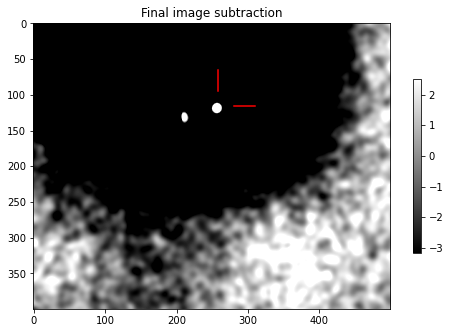

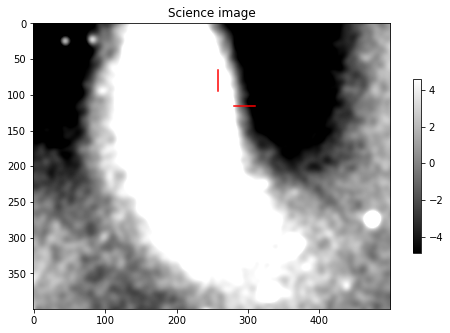

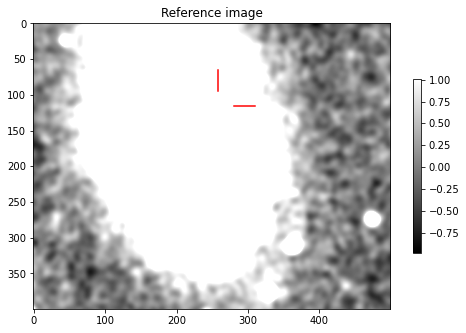

In [142]:
# Plot up the result of the image subtraction
# Tip: it must look very similar to the other two plots below..

mean, median, std = sigma_clipped_stats(image_sub)
plt.figure(figsize=(8,8))
# set the scale of the image based on its statistics
plt.imshow(image_sub[200:600,1100:1600], vmin=median-2*std, vmax=median+2*std, cmap='gray')
plt.plot([280,310],[115,115], "r-" ) # don't really know why we are using this range...
plt.plot([258,258],[95,65], "r-" )
plt.colorbar(shrink = 0.4)
##???
plt.title('Final image subtraction')
plt.show()

#...and plot up the same region of sky of science and template images (nothing to do here for you)
mean, median, std = sigma_clipped_stats(sci_conv_shift)
plt.figure(figsize=(8,8))
# set the scale of the image based on its statistics
plt.imshow(sci_conv_shift[200:600,1100:1600], vmin=median-3*std, vmax=median+3*std, cmap='gray')
plt.plot([280,310],[115,115], "r-" )
plt.plot([258,258],[95,65], "r-" )
plt.colorbar(shrink = 0.4)
plt.title('Science image')
plt.show()

mean, median, std = sigma_clipped_stats(ref_conv)
plt.figure(figsize=(8,8))
# set the scale of the image based on its statistics
plt.imshow(ref_conv[200:600,1100:1600], vmin=median-3*std, vmax=median+3*std, cmap='gray')
plt.plot([280,310],[115,115], "r-" )
plt.plot([258,258],[95,65], "r-" )
plt.colorbar(shrink = 0.4)
plt.title('Reference image')
plt.show()

# ds9 visualization
#os.system('ds9 '+sci_image_aligned_name +' ' + ref_image_aligned_name + ' sub_final.fits &')

(wow, the subtraction in the first image is actually pretty impressive! My images are way less clean for sure than the solutions to the school, but yeah the source is *very* obvious)

There you go, now you should be able to easily spot the supernova as a white excess on the grey background! <br >

Note that the bright center of the host galaxy was not perfectly subtracted and left a spurious signal that could be mistaken for real luminosity variability.  <br >


These operations can be made automatic and can be incorporated in pipelines that discover transients.  Moreover, using the methods learnt in the Photometry module, you can perform forced PSF photometry on the image subtraction to obtain flux measurement of the transient free from the host galaxy contamination.

# END OF THE SCHOOL MODULE

HOTPANTS is likely worth exploring!

### HOTPANTS

There are some packages that perform most of the operations above automatically.  One of the most popular is called HOTPANTS, which stands for "High Order Transform of PSF ANd Template Subtraction". <br >

The code can be found on GitHub: https://github.com/acbecker/hotpants 

### ZOGY

A new image-subtraction algorithm was recently developed, nicknamed "ZOGY" (an acronym made of the authors' surnames). The Zwicky Transient Facility and other optical time-domain surveys now employ the ZOGY algorithm for image subtraction.

Reference:<br>
Zackay, Ofek, Gal-Yam; The Astrophysical Journal, Volume 830, Issue 1, article id. 27, 23 pp. (2016).